<h3>Import Libraries</h3>

In [1]:
import random
import math

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(5)
%matplotlib inline

<h3>Helper Function</h3>

In [2]:
def f_indicator(boolean):
    return 1 if boolean else 0

<h3>Random Variable Generation</h3>

In [6]:
def generate_initialization_rv(number_of_companies, market_shock_rate):
    '''
    Generate all initial variables for simulating Market Value and ROI
    ----------------------
    Return
    w - market shock
    ita - idiosyncractic risk
    V - common factor that affects the economy
    '''
    w = np.random.exponential(1/market_shock_rate)
    V = np.random.normal()
    ita = np.zeros(number_of_companies)
    for i in range(number_of_companies):
        ita[i] = np.random.normal(loc=0., scale=(i+1)**0.5)
    return w, ita, V

def generate_x(w, ita, V, rho):
    '''
    Generate an instance of market value of the company according to given variables
    -------------------
    Parameters:
    w - market shock
    ita - idiosyncractic risk
    V - common factor that affects the economy
    rho - weight factor
    
    Return
    Market value of the company
    '''
    return (rho*V+ita*(1-rho**2)**0.5)/max(1, w)

def generate_y(r, x, investor_type):
    '''
    Generate an instance of return on the investment
    ---------------------
    Parameters
    r - allocation vector
    x - market value of the company
    
    Return
    U - Instance of uniform distribution r.v.
    y - Return on the investment (ROI)
    '''
    number_of_companies = len(x)
    y = np.zeros(number_of_companies)
    U = np.zeros(number_of_companies)
    for i in range(len(x)):
        U[i] = random.random()
        if investor_type == "big":
            y[i] = ((i+1) + x[i]*r[i]**2)*U[i]
        elif investor_type == "small":
            y[i] = x[i]*U[i]
        else:
            raise("Investor type not supported")
    return U, y

def generate_rv(r, rho, market_shock_rate, investor_type, number_of_companies=3):
    '''
    Simulate one instance of Market Return and ROI
    -------------------------
    Parameters
    r - allocation vector
    rho - weight factor
    
    Return 
    w - market shock
    ita - idiosyncractic risk
    V - common factor that affects the economy
    x - market value
    u - an instance of U(0,1) for y
    y - ROI
    '''
    w, ita, V = generate_initialization_rv(number_of_companies, market_shock_rate)
    x = generate_x(w, ita, V, rho)
    U, y = generate_y(r, x, investor_type)
    return w, ita, V, x, U, y

<h3>Vector Transformation Function</h3>

In [7]:
def get_allocation_vector(theta):
    '''
    Transform theta into allocation vector
    '''
    if len(theta) == 2:
        r_1 = math.cos(theta[0])
        r_2 = math.cos(theta[1])*math.sin(theta[0])
        r_3 = math.sin(theta[0])*math.sin(theta[1])
        return r_1, r_2, r_3
    else:
        raise("Only n=3 (i.e. 2-degree of freedom) is supported.")

def get_allocation_vector_gradient(theta):
    '''
    Get allocation vector gradient with given thetas
    '''
    if len(theta) == 2:
        dr1_dt1 = -math.sin(theta[0])
        dr1_dt2 = 0
        dr2_dt1 = math.cos(theta[0])*math.cos(theta[1])
        dr2_dt2 = -math.sin(theta[0])*math.sin(theta[1])
        dr3_dt1 = math.cos(theta[0])*math.sin(theta[1])
        dr3_dt2 = math.cos(theta[1])*math.sin(theta[0])
        return [dr1_dt1, dr1_dt2], [dr2_dt1, dr2_dt2], [dr3_dt1, dr3_dt2]
    else:
        raise("Only n=3 (i.e. 2-degree of freedom) is supported.")

<h3>Loss and Gradient Computation</h3>

In [8]:
def get_loss_gradient(w, ita, V, x, u, y, thresholds, theta, investor_type):
    '''
    Providing an instance of random variables, thresholds and thetas, find the loss gradient for gradient descent
    ---------------------------
    Parameters
    w - market shock
    ita - idiosyncractic risk
    V - common factor that affects the economy
    x - market value
    U - an instance of U(0,1) for y
    y - ROI
    thresholds - an array with threshold for each company
    investor_type - "big" or "small"
    
    Return
    A 2-d array with gradient update for each theta
    '''
    degree_of_freedom = len(theta)
    r = get_allocation_vector(theta)
    dr_dt = get_allocation_vector_gradient(theta)
    total_gradient = np.zeros(degree_of_freedom)
    for i in range(degree_of_freedom):
        for j in range(degree_of_freedom+1):
            if investor_type == "big":
                 total_gradient[i] += 2*f_indicator(x[j]>=thresholds[j])*(y[j]*r[j]*dr_dt[j][i]+(r[j]**3)*U[j]*x[j]*dr_dt[j][i])
            elif investor_type == "small":
                total_gradient[i] += 2*f_indicator(x[j]>=thresholds[j])*r[j]*dr_dt[j][i]*y[j]
            else:
                raise("Investor type not supported")
    return total_gradient
                   
def get_return(w, ita, V, x, u, y, thresholds, theta):
    '''
    Providing an instance of random variables, thresholds and thetas, find the loss
    ---------------------------
    Parameters
    w - market shock
    ita - idiosyncractic risk
    V - common factor that affects the economy
    x - market value
    u - an instance of U(0,1) for y
    y - ROI
    thresholds - an array with threshold for each company
    '''
    degree_of_freedom = len(theta)
    r = get_allocation_vector(theta)
    loss = 0
    for i in range(degree_of_freedom+1):
        loss += (r[i]**2)*y[i]*f_indicator(x[i]>=thresholds[i])
    return loss

In [9]:
def simulate_returns(thresholds, theta, market_shock_rate, investor_type, iterations=int(1e6)):
    '''
    Simulate expected return given an investment strategy (i.e. theta) and market properties
    -------------------------------
    Parameters
    thresholds - an array with threshold for each company
    investor_type - "big"/"small"
    
    Return
    An array with simulation result of returns
    '''
    r = get_allocation_vector(theta)
    return_history = np.zeros(iterations)
    for i in range(iterations):
        w, ita, V, x, U, y = generate_rv(r, rho, market_shock_rate, investor_type)
        return_history[i] = get_return(w, ita, V, x, U, y, thresholds, theta)
    return return_history

<h3>Gradient Descent</h3>

<h4>Problem Parameters</h4>

In [10]:
thresholds = [2,3,1]
rho = 0.6
market_shock_rate = 1./0.3

<h4>Small Investor</h4>

In [11]:
investor_type = "small"
iterations = int(5e5)
epsilon = 1e-4
theta_small = [0.5, 0.5]
theta_history_small = np.zeros([iterations, 2])
for i in range(iterations):
    theta_history_small[i] = theta_small
    r = get_allocation_vector(theta_small)
    w, ita, V, x, U, y = generate_rv(r, rho, market_shock_rate, investor_type)
    loss_gradient = get_loss_gradient(w, ita, V, x, U, y, thresholds, theta_small, investor_type)
    theta_small += epsilon*loss_gradient

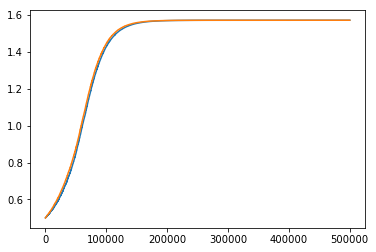

In [12]:
plt.plot([i for i in range(iterations)], theta_history_small)

In [13]:
return_history_small = simulate_returns(thresholds, theta_small, market_shock_rate, investor_type)

In [14]:
print("Optimal theta [theta_1, theta_2]: {0}".format(theta_small))
print("Mean of return: {0}".format(return_history_small.mean()))

Optimal theta [theta_1, theta_2]: [ 1.57079632  1.57079632]
Mean of return: 0.2398127000352055


<h4>Big Investor</h4>

In [15]:
investor_type = "big"
iterations = int(5e5)
epsilon = 1e-4
theta_big = [0.5, 0.5]
theta_history_big = np.zeros([iterations, 2])
for i in range(iterations):
    theta_history_big[i] = theta_big
    r = get_allocation_vector(theta_big)
    w, ita, V, x, U, y = generate_rv(r, rho, market_shock_rate, investor_type)
    loss_gradient = get_loss_gradient(w, ita, V, x, U, y, thresholds, theta_big, investor_type)
    theta_big += epsilon*loss_gradient

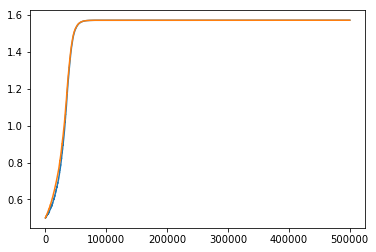

In [16]:
plt.plot([i for i in range(iterations)], theta_history_big)

In [17]:
return_history_big = simulate_returns(thresholds, theta_big, market_shock_rate, investor_type)

In [18]:
print("Optimal theta [theta_1, theta_2]: {0}".format(theta_big))
print("Mean of return: {0}".format(return_history_big.mean()))

Optimal theta [theta_1, theta_2]: [ 1.57079633  1.57079633]
Mean of return: 0.6156473379462318
